# 3.2 Contrastive Learning

In this part of the tutorial we will be looking at contrastive learning. We will train a Siamese neural network to discriminate samples based on the similarity / contrast between them. A Siamese neural network is a regular neural network that takes 2 samples as input and processes them in parallel with the same set of parameters.

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Tuple
import random as rd
from sklearn.cluster import KMeans
from sklearn.metrics import rand_score

torch.manual_seed(0)
rd.seed(0)

## Data

We will again be using the MNIST dataset. However, we will slightly extend it. As mentioned, our network takes 2 samples as input. In our case the first sample is random, while the second sample has a 50/50 chance to be either another random sample from the same class or a random sample from another random class. In the former case the associated label is 1 since the 2 samples are similar, and in the latter case the label is 0. Although we might be cheating a little bit since we are using the labels, in practice the *similarity* can be defined in many ways. For example, in computer vision often the inputs are random crops of images and if the crops are from the same image, then they are similar. In such cases the labels are not used at all but that comes at the cost of way slower training and huge amounts of required data.

In [2]:
class PairedDigits(Dataset):
    def __init__(self):
        self.mnist = MNIST('data', transform=transforms.ToTensor(), download=True)
        
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        
        # Get the first sample as usual
        image, label = self.mnist[idx]

        # 50/50 chance to get a similar 2nd sample
        similarity_label = rd.random() > .5
        
        # Filter the samples based on the similarity label
        if similarity_label:
            other_indices = self.mnist.targets == label
        else:
            other_indices = self.mnist.targets != label

        # Get the second random sample
        other_idx = rd.choice(other_indices.nonzero()[:, 0])
        other, other_label = self.mnist[other_idx]
        
        return image, other, similarity_label * 1. # Multply by 1. to convert True -> 1. and False -> 0.

dataset = PairedDigits()
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

## Model

Our model is a regular feed forward neural network that embeds the input images into the laten space. In our case, the latent space will be 2-dimensional so that we can visualize it. Keep in mind that this is a 99.75% reduction (28 x 28 -> 2)

In [3]:
class ContrastiveModel(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        
    def forward(self, image: torch.Tensor, other: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        # Do the forward pass for both samples
        return (
            self.encoder(image),
            self.encoder(other)
        )

model = ContrastiveModel()
optimizer = torch.optim.Adam(params=model.parameters())

Now we can define out contrastive loss. Given 2 embeddings $x_1\in\mathbb{R}^q$, $x_2\in\mathbb{R}^q$, and the binary similarity label $y\in
\{0,1\}$, the contrastive loss is defined as follows:

$$\ell(x_1,x_2,y) = y\frac{h(x_1,x_2)}{2} + (1-y)\frac{\max\{0,m-h(x_1,x_2)\}}{2}$$

Here $m$ is a hyperparameter, the 'margin'. We will use $m=1$, feel free to change it and see what happens. $h:\mathbb{R}^q\times \mathbb{R}^q\to\mathbb{R}$ is a distance/dissimilarity metric. Most commonly, $h(x_1,x_2)$ is the squared Euclidean distance between $x_1$ and $x_2$, i.e. $h(x_1,x_2)=||x_1-x_2||_2^2$. Small side quest: Why is calculating the square of the distance faster than calculating the distance itself?

Intuitively, the loss function embodies 2 cases:

- $y=1$. In this case only the first term is non-zero. Since the samples are 'similar', we aim to minimize the distance between them, so the loss is proportional to $h$.
- $y=0$. In this case only the second term is non-zero. Since the samples are 'dissimilar', we aim to maximize the distance, so we have negative $h$. The margin $m$ is used to bind the embedding since two samples can be repelled forever ($h\to\infty$). We are basically saying that if the 2 samples are $m$ distance apart, they are already far enough, so the loss is 0.


In [4]:
def contrastive_loss(x1: torch.Tensor, x2: torch.Tensor, y: torch.Tensor, m: float = 1.) -> torch.Tensor:
    h = torch.linalg.norm(x1 - x2, dim=1) ** 2
    loss = y * h / 2 + (1 - y) * torch.clamp(m - h, min=0) / 2
    return loss.mean()

The training procedure is the same as always.

In [5]:
for epoch in range(5):
    model.train()
    total_loss = 0.
    for X1, X2, y in tqdm(dataloader):

        # Flatten the images from [batch_size, 1, 28, 28] -> [batch_size, 1*28*28]
        X1, X2 = X1.flatten(1), X2.flatten(1)
        
        optimizer.zero_grad()
        y1, y2 = model(X1, X2)
        loss = contrastive_loss(y1, y2, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch} | Loss: {total_loss/len(dataloader):.4f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:35<00:00, 16.82it/s]


Epoch 0 | Loss: 0.0859


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:34<00:00, 17.43it/s]


Epoch 1 | Loss: 0.0501


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:35<00:00, 17.11it/s]


Epoch 2 | Loss: 0.0364


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:38<00:00, 15.53it/s]


Epoch 3 | Loss: 0.0300


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:39<00:00, 15.34it/s]

Epoch 4 | Loss: 0.0246


Our model is definitely learning!

## Evaluation

To visualize the latent space, we simply need to embed all training images using our trained model.

In [6]:
# We make a new dataloader for the mnist dataset only
mnist_dataloader = DataLoader(dataset.mnist, batch_size=100)

with torch.inference_mode():
    predictions, labels = zip(*[(model.encoder(X.flatten(1)), y) for X, y in mnist_dataloader])
    predictions = torch.cat(predictions)
    labels = torch.cat(labels)

Now we can just plot the samples in the embedding space

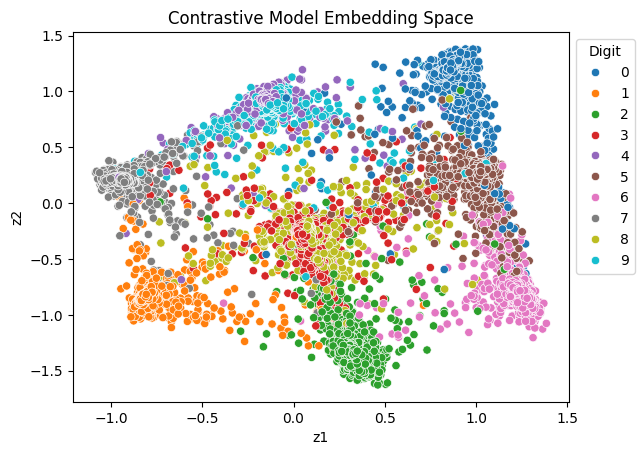

In [7]:
sns.scatterplot(x=predictions[:, 0], y=predictions[:, 1], hue=labels, palette='tab10')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Contrastive Model Embedding Space')
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1), title='Digit')
plt.show()

Although it seems like the samples are all over the place, they are still clustered in very tight clusters, it's just that the plot above shows all 60 000 samples. To confirm that, we can plot the densities of the clusters. We can also notice that the embedding is quite tight as it is roughly contained in the circle with center (0,0) and radius $m$.

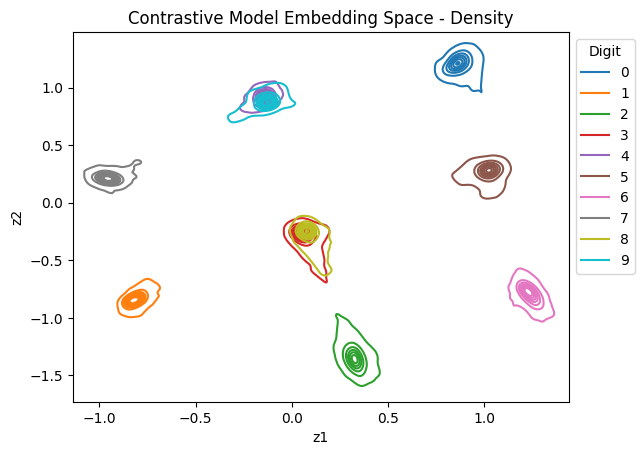

In [8]:
sns.kdeplot(x=predictions[:, 0], y=predictions[:, 1], hue=labels, palette='tab10')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Contrastive Model Embedding Space - Density')
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1), title='Digit')
plt.show()

Indeed the clusters are very far apart except for some pairs that did not manage to separate. It might be because we are working in only 2 dimensions so it is quite hard to fit all samples in the small circle. Still quite good! We can quantitatively evaluate the resulting clustering by fitting a model on the embedding space. Since the cluster appear to have almost circular densities, we can use Kmeans:

In [29]:
kmeans = KMeans(10) # We have 10 digits
kmeans.fit(predictions)
cluster_assignments = kmeans.predict(predictions)
rand_score(labels, cluster_assignments)

0.9555589804274516

We get a Rand Index of 0.95, which is the probability that the two clusterings (in our case the ground truth labels and the learned cluster assignments) agree on a given random sample. This is very good! Contrastive learning has been quite effective.

In [30]:
within_cluster_distances = torch.zeros(10)
centers = torch.from_numpy(kmeans.cluster_centers_).float()
for i in range(10):
    within_cluster_distances[i] = torch.linalg.norm(predictions[cluster_assignments == i] - centers[i].unsqueeze(0), dim=1).mean()
between_custer_distances = torch.linalg.norm(centers.unsqueeze(1) - centers.unsqueeze(0), dim=2)
between_custer_distances[between_custer_distances == 0] = torch.inf
davies_bouldin_index = (
    (within_cluster_distances.unsqueeze(1) + within_cluster_distances.unsqueeze(0)) / between_custer_distances
).amax(dim=1).mean()
davies_bouldin_index

tensor(0.3538)